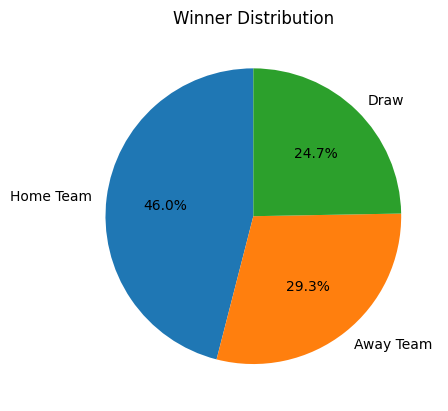

In [1]:
import pandas as pd

seasons = [
    '00_01', '01_02', '02_03', '03_04', '04_05',
    '05_06', '06_07', '07_08', '08_09', '09_10',
    '10_11', '11_12', '12_13', '13_14', '14_15',
    '15_16', '16_17', '17_18', '18_19', '19_20',
    '20_21', '21_22', '22_23', '23_24'
]


df = pd.DataFrame()

for season in seasons:
    df = pd.concat([df, pd.read_csv(f'../statistical_data/{season}/E0.csv', encoding='unicode_escape')])
    # df = pd.concat([df, pd.read_csv(f'./statistical_data/{season}/D1.csv')])
    # df = pd.concat([df, pd.read_csv(f'./statistical_data/{season}/I1.csv')])
    # df = pd.concat([df, pd.read_csv(f'./statistical_data/{season}/SP1.csv')])
    # df = pd.concat([df, pd.read_csv(f'./statistical_data/{season}/F1.csv')])


import matplotlib.pyplot as plt
ftr_map = {'H': 'Home Team', 'D': 'Draw', 'A': 'Away Team'}
df['FTR'] = df['FTR'].map(ftr_map)
df['FTR'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Winner Distribution')
plt.axis('off')
plt.show()

In [13]:
import pandas as pd

# Functions for calculations
def calculate_team_mean(df, team, cutoff_date, metric):
    cutoff_date = pd.Timestamp(cutoff_date)
    df_filtered = df[
        ((df["HomeTeam"] == team) | (df["AwayTeam"] == team)) &
        (df['Date'] < cutoff_date)
    ].sort_values('Date', ascending=False).head(5)
    
    if df_filtered.empty:
        return None
    
    mean = df_filtered.apply(
        lambda row: row[metric] if row['HomeTeam'] == team else row['H' + metric[1:].replace('H', 'A')], axis=1
    ).mean()
    return mean

def calculate_points(df, team, cutoff_date):
    cutoff_date = pd.Timestamp(cutoff_date)
    df_filtered = df[
        ((df["HomeTeam"] == team) | (df["AwayTeam"] == team)) &
        (df['Date'] < cutoff_date)
    ].sort_values('Date', ascending=False).head(5)
    
    if df_filtered.empty:
        return None
    
    points = df_filtered.apply(
        lambda row: 3 if (row['HomeTeam'] == team and row['FTR'] == 'H') or
                     (row['AwayTeam'] == team and row['FTR'] == 'A') else
                     1 if row['FTR'] == 'D' else 0, axis=1
    ).mean()
    return points

# Main pipeline
cols_to_leave = ['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST']
metrics = ['FTHG', 'HS', 'HST']
map = {
    'FTHG': 'FullTimeGoals',
    'HS': 'Shots',
    'HST': 'ShotsOnTarget'
}

df_list = []
seasons = ['21_22', '22_23', '23_24']

for season in seasons:
    # Load and preprocess data
    df = pd.read_csv(f'../statistical_data/{season}/E0.csv')
    df = df[cols_to_leave]
    try:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y')
    except ValueError:
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

    teams = set(df['HomeTeam']).union(set(df['AwayTeam']))
    for team in teams:
        subset = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
        dates = subset['Date'].unique()
        for date in dates:
            # Calculate mean statistics for each metric
            for metric in metrics:
                mean = calculate_team_mean(df, team, date, metric)
                if mean is not None:
                    if subset[subset['Date'] == date]['HomeTeam'].values[0] == team:
                        df.loc[(df['HomeTeam'] == team) & (df['Date'] == date), f'HomeTeam_{map[metric]}_mean'] = mean
                    else:
                        df.loc[(df['AwayTeam'] == team) & (df['Date'] == date), f'AwayTeam_{map[metric]}_mean'] = mean

            # Calculate points for the team
            points = calculate_points(df, team, date)
            if points is not None:
                if subset[subset['Date'] == date]['HomeTeam'].values[0] == team:
                    df.loc[(df['HomeTeam'] == team) & (df['Date'] == date), 'HomeTeam_points'] = points
                else:
                    df.loc[(df['AwayTeam'] == team) & (df['Date'] == date), 'AwayTeam_points'] = points

        df_home = df[df['HomeTeam'] == team]
        df_away = df[df['AwayTeam'] == team]

        distr_home = df[df['HomeTeam'] == team]['FTR'].value_counts(normalize=True).to_dict()
        distr_away = df[df['AwayTeam'] == team]['FTR'].value_counts(normalize=True).to_dict()

        df_distr = pd.DataFrame(columns=['team', 'home', 'away'])

        df_distr = pd.concat([df_distr, pd.DataFrame({'team': team, 'home': [distr_home], 'away': [distr_away]})])
        df_distr['home_rate'] = df_distr['home'].apply(lambda x: 3 * x.get('H', 0) + x.get('D', 0))
        df_distr['away_rate'] = df_distr['away'].apply(lambda x: 3 * x.get('A', 0) + x.get('D', 0))

        df.loc[df['HomeTeam'] == team, 'HomeTeamRate'] = df_distr[df_distr['team'] == team]['home_rate'].values[0]
        df.loc[df['AwayTeam'] == team, 'AwayTeamRate'] = df_distr[df_distr['team'] == team]['away_rate'].values[0]

    df_list.append(df)

# Combine data for all seasons
df = pd.concat(df_list)

df['season'] = df['Date'].apply(lambda x: x.year if x.month < 7 else x.year + 1)

df['HomeTeamRate'] = df.groupby(['HomeTeam', 'season'])['HomeTeamRate'].shift(1)
df['AwayTeamRate'] = df.groupby(['AwayTeam', 'season'])['AwayTeamRate'].shift(1)

df

,Date,HomeTeam,AwayTeam,FTR,FTHG,FTAG,HTHG,HTAG,HS,AS,...,HomeTeam_Shots_mean,HomeTeam_ShotsOnTarget_mean,HomeTeam_points,AwayTeam_FullTimeGoals_mean,AwayTeam_Shots_mean,AwayTeam_ShotsOnTarget_mean,AwayTeam_points,HomeTeamRate,AwayTeamRate,season
0,2021-08-13,Brentford,Arsenal,H,2,0,1,0,8,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
1,2021-08-14,Man United,Leeds,H,5,1,1,0,16,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
2,2021-08-14,Burnley,Brighton,A,1,2,1,0,14,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
3,2021-08-14,Chelsea,Crystal Palace,H,3,0,2,0,13,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
4,2021-08-14,Everton,Southampton,H,3,1,0,1,14,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2024-05-19,Crystal Palace,Aston Villa,H,5,0,2,0,15,8,...,15.6,6.6,2.6,1.6,15.0,5.0,1.6,1.473684,1.473684,2024
376,2024-05-19,Liverpool,Wolves,H,2,0,2,0,36,4,...,16.6,7.4,1.6,0.6,13.2,6.2,0.6,2.526316,1.000000,2024
377,2024-05-19,Luton,Fulham,A,2,4,1,2,15,15,...,18.8,6.8,0.2,0.6,8.8,3.0,1.0,0.842105,0.947368,2024
378,2024-05-19,Man City,West Ham,H,3,1,2,1,28,3,...,10.4,4.6,3.0,1.2,18.6,8.2,0.8,2.473684,1.210526,2024


In [14]:
map = {
     'H': 3,
     'D': 1,
     'A': 0
}

df['FTR'] = df['FTR'].map(map)

In [15]:
df.reset_index(drop=True, inplace=True)
df.dropna(inplace=True)

In [16]:
from sklearn.model_selection import train_test_split

X = df[['HomeTeam_FullTimeGoals_mean', 'AwayTeam_FullTimeGoals_mean',
        # 'HomeTeam_HalfTimeGoals_mean', 'AwayTeam_HalfTimeGoals_mean', 
        'HomeTeam_Shots_mean', 'AwayTeam_Shots_mean', 
        'HomeTeam_ShotsOnTarget_mean', 'AwayTeam_ShotsOnTarget_mean', 
        'HomeTeam_points', 'AwayTeam_points',
          'HomeTeamRate', 'AwayTeamRate'
        ]]

y = df['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.52      0.52        67
           1       0.25      0.08      0.12        48
           3       0.60      0.78      0.68       101

    accuracy                           0.55       216
   macro avg       0.45      0.46      0.44       216
weighted avg       0.50      0.55      0.51       216



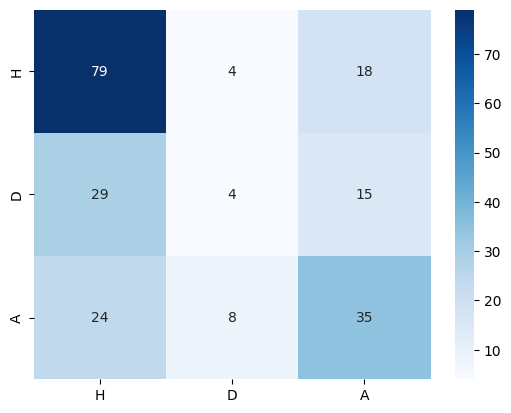

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cm = cm[::-1, ::-1]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['H', 'D', 'A'], yticklabels=['H', 'D', 'A'])
plt.show()

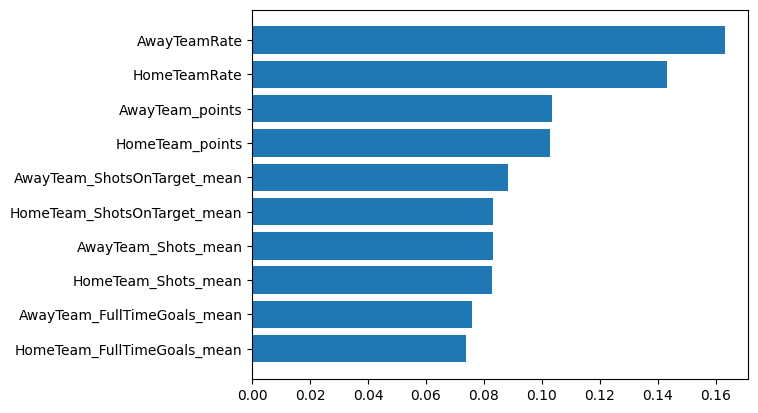

In [19]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
sorted_idx = importances.argsort()

plt.barh(X.columns, importances[sorted_idx])
plt.show()

# featre ideas

# current season elo
# xG
# goal difference
# goals conceded
# corners
# separate metrics by home and away performance and maybe even by times